In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nbodykit_pk as nbodypk

from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [9]:
filename = '/home/jwack/data_files/HMQELG-eBOSS-density.gcat' 
BoxSize = 1000
delta_k = 0.00687050087737447 # 30 bins for Nmesh=64

## Compare effect of different Nmesh in real space

In [4]:
def get_binned_power(cat, Nmesh, bin_type):
    '''bin_type should be 'lin' or 'log'.
    To aviod binning artefacts, choose a fixed bin width, which will give 30 bins for Nmesh=64. 
    To reduce run time for large Nmesh, take delta_k larger.'''
    k_Nyq = np.pi*Nmesh/BoxSize
    k_min = 0.005
    k_max = k_Nyq*1.05 # FFTPower only computes upto k_max 
    Nk = int((k_max - k_min)/delta_k) # number of bin edges
    kbin = [k_min, k_max, Nk, bin_type]
    
    mesh = cat.to_mesh(position='Position', resampler='tsc', BoxSize=BoxSize, Nmesh=Nmesh, compensated=True)
    pkout = nbodypk.get_binned_Pk(mesh, kbin)
    
    return pkout

Loading HMQELG-eBOSS-density.gcat
Compute for Nmesh=64
CPU times: user 503 ms, sys: 284 ms, total: 787 ms
Wall time: 1.17 s
--------------------------------
Compute for Nmesh=256
CPU times: user 1.36 s, sys: 1.92 s, total: 3.28 s
Wall time: 3.32 s
--------------------------------
Compute for Nmesh=1024
CPU times: user 58.4 s, sys: 3.14 s, total: 1min 1s
Wall time: 1min 1s
--------------------------------


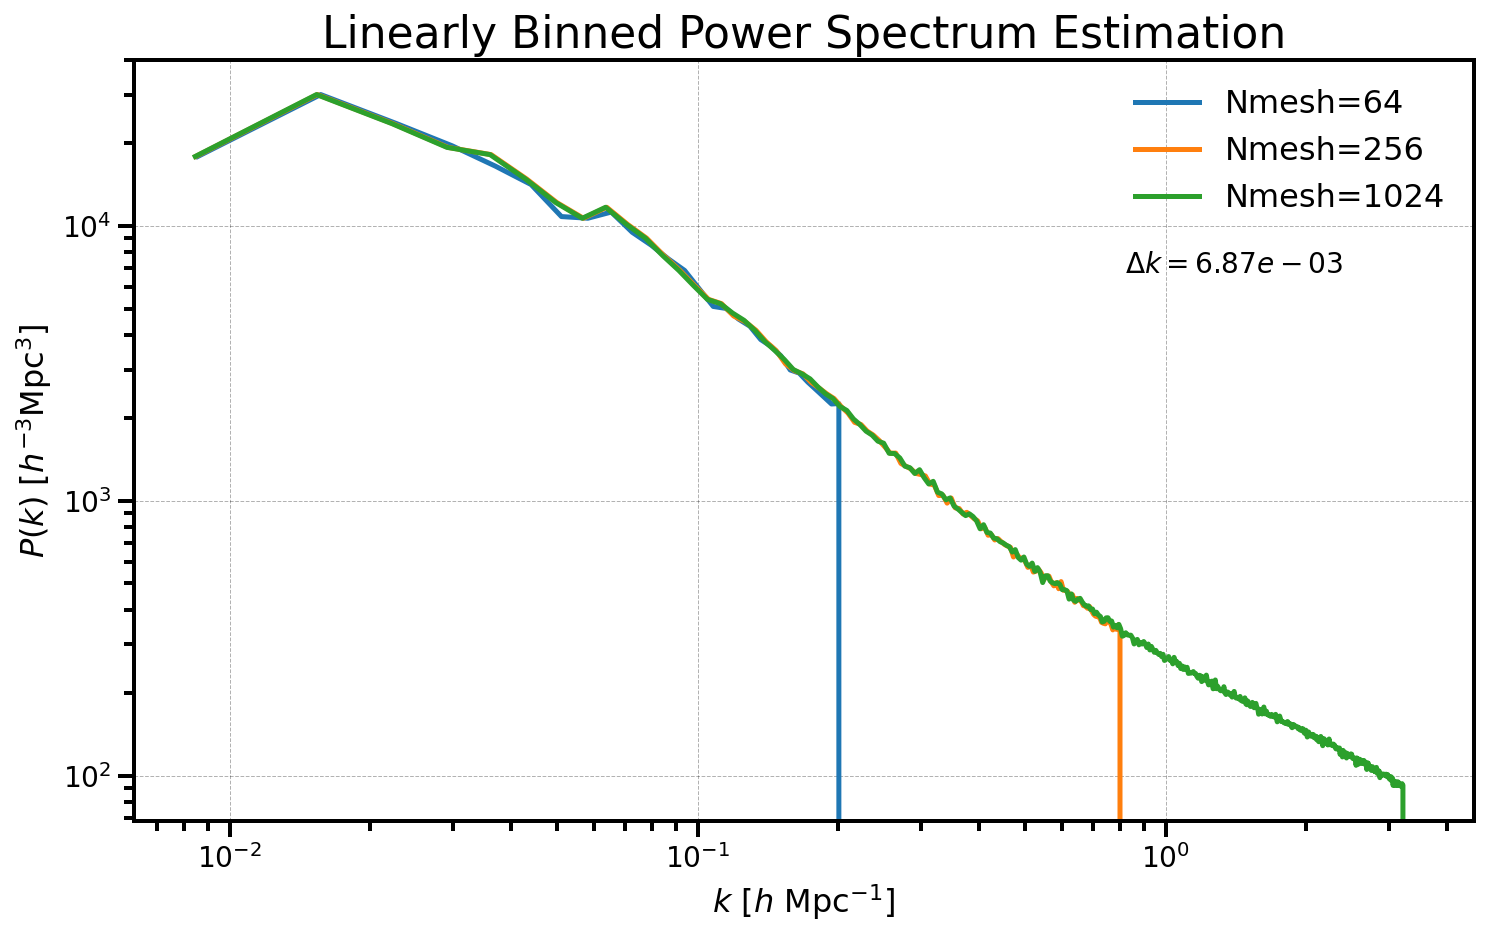

In [5]:
Ns = [64, 256, 1024]

cat = nbodypk.make_cat(filename)

fig = plt.figure()
for Nmesh in Ns:
    print("Compute for Nmesh=%d" %Nmesh)
    %time pkout = get_binned_power(cat, Nmesh, 'lin')
    print("-"*32)
    plt.loglog(pkout[:,0], pkout[:,1], label="Nmesh={:d}".format(Nmesh))
    
plt.title("Linearly Binned Power Spectrum Estimation")
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.text(0.74, 0.72, "$\Delta k={:.2e}$".format(delta_k), transform=plt.gca().transAxes)
plt.legend(frameon=False)

plt.show()
fname = "plots_non_analysis/Nmesh_compare.pdf"
#fig.savefig(fname)

### Interpretation
Overall, power spectra are identical upto interpolation artefacts. Shows that `Nmesh` is a nuisance parameter i.e. has no real effect.

The cut-off is due to $k_{Nyq}$ being proportional to `Nmesh`. I chose the same bin width for all values of `Nmesh`. This value will produce 30 bins for `Nmesh=64` and correspondingly more for larger `Nmesh`. Choosing a constant width and varying number of bins rather than the other way around is beneficial when comparing the results for different `Nmesh` as otherwise the bin width grows with `Nmesh` causing the first data point being pushed to the right since it is the average of the FFT data inside a k bin, plotted at the middle of the k bin (See Slack message 20.06).

Recall that aliasing only becomes significant at large $k$. Here `BoxSize` to large s.t. $k_{Nyq}$ to small to observe notable change in plot when setting `interlacing=True` when mesh is generated. 